In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow.keras import models

In [5]:
# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25
n_classes = 15


In [6]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Animals Dataset/15-class",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 900 files belonging to 15 classes.


In [7]:
class_names = dataset.class_names
class_names

['beetle',
 'bison',
 'cow',
 'coyote',
 'dog',
 'dolphin',
 'fox',
 'goose',
 'gorilla',
 'grasshopper',
 'hornbill',
 'jellyfish',
 'leopard',
 'lobster',
 'woodpecker']

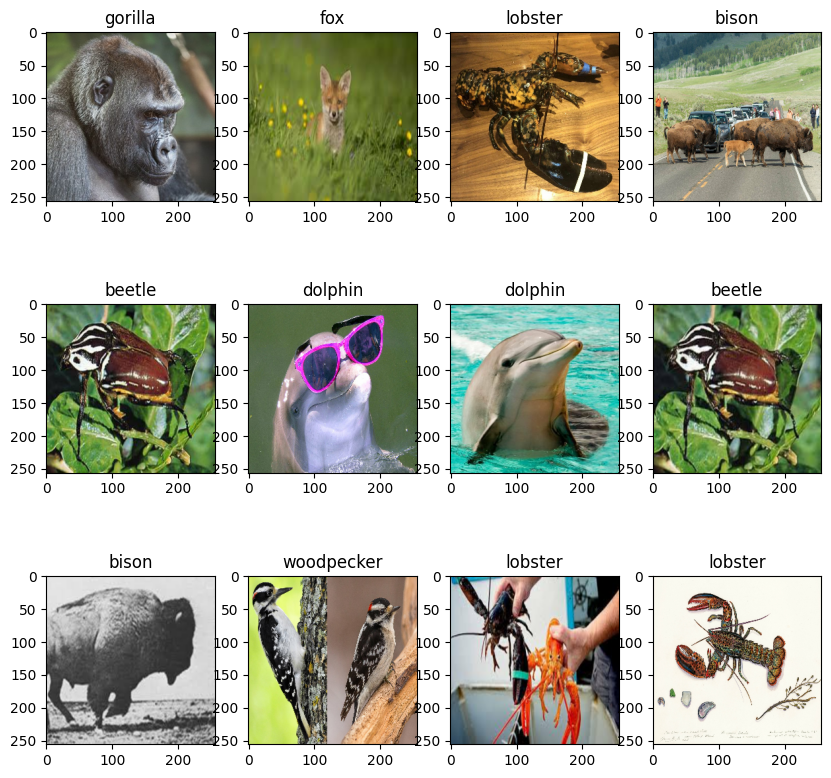

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

In [9]:
# Split dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=1000):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [11]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

23
2
4


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [16]:
import numpy as np
from sklearn.model_selection import KFold

# Convert dataset to numpy arrays
X = []
y = []
for images, labels in dataset.as_numpy_iterator():
    for image in images:
        # Resize each image to a consistent size
        resized_image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
        X.append(resized_image)
    y.extend(labels)
X = np.array(X)
y = np.array(y)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to store evaluation results
binary_accuracy_per_fold = []  # Ensure it's a Python list
training_accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_score_per_fold = []

# Define K-fold cross-validation
kf = KFold(n_splits=num_folds)


In [21]:
# Iterate over folds
for fold_idx, (train_indices, test_indices) in enumerate(kf.split(X, y)):
    print(f"Fold {fold_idx+1}:")

    # Get train and test indices for this fold
    train_X, test_X = X[train_indices], X[test_indices]
    train_y, test_y = y[train_indices], y[test_indices]

    # Initialize a list to store binary classifiers for this fold
    binary_classifiers_fold = []
    training_accuracy_per_classifier = []

    # Initialize lists to store metrics for this fold
    fold_binary_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1_score = []

    # Train one binary classifier for each class
    for class_index in range(n_classes):
        # Clone the original model
        binary_model = tf.keras.models.clone_model(model)

        # Replace the last Dense layer with a binary classifier
        binary_model.pop()  # Remove the last layer
        binary_model.add(layers.Dense(1, activation='sigmoid'))  # Binary classifier

        # Compile the binary model
        binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Prepare dataset for binary classification
        binary_train_indices_pos = np.where(train_y == class_index)[0]
        binary_train_indices_neg = np.where(train_y != class_index)[0][:len(binary_train_indices_pos)]  # Balance the dataset
        binary_train_indices = np.concatenate((binary_train_indices_pos, binary_train_indices_neg))
        np.random.shuffle(binary_train_indices)  # Shuffle indices
        binary_train_X, binary_train_y = train_X[binary_train_indices], (train_y[binary_train_indices] == class_index).astype(np.float32)

        binary_test_indices_pos = np.where(test_y == class_index)[0]
        binary_test_indices_neg = np.where(test_y != class_index)[0][:len(binary_test_indices_pos)]  # Balance the dataset
        binary_test_indices = np.concatenate((binary_test_indices_pos, binary_test_indices_neg))
        np.random.shuffle(binary_test_indices)  # Shuffle indices
        binary_test_X, binary_test_y = test_X[binary_test_indices], (test_y[binary_test_indices] == class_index).astype(np.float32)

        # Train the binary classifier
        history = binary_model.fit(binary_train_X, binary_train_y, epochs=EPOCHS, verbose=0)

        # Calculate training accuracy
        binary_train_predictions = (binary_model.predict(binary_train_X) > 0.5).astype("int32").flatten()
        binary_train_accuracy = accuracy_score(binary_train_y, binary_train_predictions)
        print(f"Binary Classifier for class {class_index}: Training Accuracy = {binary_train_accuracy}")
        training_accuracy_per_classifier.append(binary_train_accuracy)

        # Evaluate the binary classifier on test set
        binary_test_predictions = (binary_model.predict(binary_test_X) > 0.5).astype("int32").flatten()
        binary_accuracy = accuracy_score(binary_test_y, binary_test_predictions)

        # Store the accuracy for this binary classifier
        fold_binary_accuracy.append(binary_accuracy)

        precision = precision_score(binary_test_y, binary_test_predictions)
        recall = recall_score(binary_test_y, binary_test_predictions)
        f1 = f1_score(binary_test_y, binary_test_predictions)

        #print(f"Binary Classifier for class {class_index}: Testing Accuracy = {binary_accuracy}")
        #print(f"Binary Classifier for class {class_index}: Precision = {precision}")
        #print(f"Binary Classifier for class {class_index}: Recall = {recall}")
        #print(f"Binary Classifier for class {class_index}: F1 Score = {f1}")

        # Store metrics for this fold
        fold_precision.append(precision)
        fold_recall.append(recall)
        fold_f1_score.append(f1)

        # Add the trained binary classifier to the list
        binary_classifiers_fold.append(binary_model)

    # Store the binary classifier accuracies for this fold
    binary_accuracy_per_fold.append(fold_binary_accuracy.copy())  # Ensure we're appending a copy, not a reference
    training_accuracy_per_fold.append(training_accuracy_per_classifier)
    precision_per_fold.append(fold_precision)
    recall_per_fold.append(fold_recall)
    f1_score_per_fold.append(fold_f1_score)

Fold 1:
3/3 [==============================] - 0s 16ms/step
Binary Classifier for class 0: Training Accuracy = 0.7790697674418605
3/3 [==============================] - 0s 15ms/step
Binary Classifier for class 1: Training Accuracy = 0.8857142857142857
3/3 [==============================] - 0s 16ms/step
Binary Classifier for class 2: Training Accuracy = 0.8780487804878049
3/3 [==============================] - 0s 15ms/step
Binary Classifier for class 3: Training Accuracy = 0.8125
3/3 [==============================] - 0s 14ms/step
Binary Classifier for class 4: Training Accuracy = 0.6323529411764706
3/3 [==============================] - 0s 16ms/step
Binary Classifier for class 5: Training Accuracy = 0.9375
3/3 [==============================] - 0s 24ms/step
Binary Classifier for class 6: Training Accuracy = 0.8260869565217391
3/3 [==============================] - 0s 16ms/step
Binary Classifier for class 7: Training Accuracy = 0.782051282051282
3/3 [==============================] - 0s

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [19]:

# Convert lists to numpy arrays
binary_accuracy_per_fold = np.array(binary_accuracy_per_fold)
training_accuracy_per_fold = np.array(training_accuracy_per_fold)
precision_per_fold = np.array(precision_per_fold)
recall_per_fold = np.array(recall_per_fold)
f1_score_per_fold = np.array(f1_score_per_fold)

# Calculate mean and standard deviation for each metric
mean_binary_accuracy = np.mean(binary_accuracy_per_fold, axis=0)
std_binary_accuracy = np.std(binary_accuracy_per_fold, axis=0)

mean_training_accuracy = np.mean(training_accuracy_per_fold, axis=0)
std_training_accuracy = np.std(training_accuracy_per_fold, axis=0)

mean_precision = np.mean(precision_per_fold, axis=0)
std_precision = np.std(precision_per_fold, axis=0)

mean_recall = np.mean(recall_per_fold, axis=0)
std_recall = np.std(recall_per_fold, axis=0)

mean_f1_score = np.mean(f1_score_per_fold, axis=0)
std_f1_score = np.std(f1_score_per_fold, axis=0)

TypeError: unsupported operand type(s) for +: 'Sequential' and 'Sequential'

In [ ]:
# Plot training and testing accuracies
plt.errorbar(range(1, n_classes+1), mean_binary_accuracy, yerr=std_binary_accuracy, fmt='-o', label='Testing Accuracy')
plt.errorbar(range(1, n_classes+1), mean_training_accuracy, yerr=std_training_accuracy, fmt='-o', label='Training Accuracy')
plt.xlabel('Class Index')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.xticks(range(1, n_classes+1))
plt.grid(True)
plt.show()

# Plot other evaluation metrics
plt.errorbar(range(1, n_classes+1), mean_precision, yerr=std_precision, fmt='-o', label='Precision')
plt.errorbar(range(1, n_classes+1), mean_recall, yerr=std_recall, fmt='-o', label='Recall')
plt.errorbar(range(1, n_classes+1), mean_f1_score, yerr=std_f1_score, fmt='-o', label='F1 Score')
plt.xlabel('Class Index')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.legend()
plt.xticks(range(1, n_classes+1))
plt.grid(True)
plt.show()